In [1]:
import xarray as xr
import numpy as np
import os

def inspect_netcdf_files():
    """Loads the HRRR and Ice training files and prints their structure."""
    
    # NOTE: Update these paths if your files are located elsewhere
    TRAIN_HRRR_PATH = "train/hrrr_20190111-20190131.nc"
    TRAIN_ICE_PATH = "train/ice_20190111-20190131.nc"
    
    # --- Inspect HRRR Training Data ---
    if not os.path.exists(TRAIN_HRRR_PATH):
        print(f"Error: HRRR file not found at {TRAIN_HRRR_PATH}")
        return
        
    print(f"\n--- HRRR Training Data Structure: {TRAIN_HRRR_PATH} ---")
    try:
        hrrr_ds = xr.open_dataset(TRAIN_HRRR_PATH)
        print("\n[ Dimensions ]")
        print(hrrr_ds.dims)
        
        print("\n[ Variables / Fields ]")
        # Print key variables, their dimensions, and the first element's size
        for name, var in hrrr_ds.variables.items():
            print(f"  - {name} ({', '.join(var.dims)}): {var.shape}")
        
        print("\n[ Global Attributes ]")
        print(hrrr_ds.attrs)
        
    except Exception as e:
        print(f"Error loading HRRR dataset: {e}")

    # --- Inspect Ice Training Data ---
    if not os.path.exists(TRAIN_ICE_PATH):
        print(f"Error: Ice file not found at {TRAIN_ICE_PATH}")
        return

    print(f"\n--- ICE Training Data Structure: {TRAIN_ICE_PATH} ---")
    try:
        ice_ds = xr.open_dataset(TRAIN_ICE_PATH)
        print("\n[ Dimensions ]")
        print(ice_ds.dims)
        
        print("\n[ Variables / Fields ]")
        for name, var in ice_ds.variables.items():
            print(f"  - {name} ({', '.join(var.dims)}): {var.shape}")
            
        print("\n[ Global Attributes ]")
        print(ice_ds.attrs)

    except Exception as e:
        print(f"Error loading Ice dataset: {e}")


if __name__ == "__main__":
    inspect_netcdf_files()


--- HRRR Training Data Structure: train/hrrr_20190111-20190131.nc ---

[ Dimensions ]
FrozenMappingWarningOnValuesAccess({'time': 696, 'y': 365, 'x': 604})

[ Variables / Fields ]
  - PRATE_surface (time, y, x): (696, 365, 604)
  - air_temp (time, y, x): (696, 365, 604)
  - latitude (y, x): (365, 604)
  - longitude (y, x): (365, 604)
  - pressure_sea_level (time, y, x): (696, 365, 604)
  - rel_humidty (time, y, x): (696, 365, 604)
  - sky_cover (time, y, x): (696, 365, 604)
  - time (time): (696,)
  - windu (time, y, x): (696, 365, 604)
  - windv (time, y, x): (696, 365, 604)
  - x (x): (604,)
  - y (y): (365,)

[ Global Attributes ]
{'Conventions': 'CF-1.0', 'GRIB2_grid_template': 30, 'History': 'Mon Nov  2 21:22:14 2020: ncks -O --deflate 1 nc_files/hrrr201901100.nc nc_files/hrrr201901100.nc\nMon Nov  2 21:22:14 2020: ncrename -v .TMP_2maboveground,air_temp -v .DPT_2maboveground,dewpt_temp -v .MSLMA_meansealevel,pressure_sea_level -v .PRES_surface,pressure -v .UGRD_10maboveground,wi

In [1]:
import numpy as np
import xarray as xr
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import os
import sys

# --- File Paths ---
TRAIN_HRRR_PATH = "train/hrrr_20190111-20190131.nc"
TRAIN_ICE_PATH = "train/ice_20190111-20190131.nc"

# --- Configuration for Testing ---
# Set this to 97 to run the full 96-hour forecast period (t=0 to t=96).
HRRR_TIME_STEPS_TO_PROCESS = 97 
# The full data contains 696 time steps, but we only need the first 97 hours for a 96h forecast.

# --- Data Loading ---
print("STATUS: Loading datasets...")
try:
    hrrr_ds = xr.open_dataset(TRAIN_HRRR_PATH)
    ice_ds = xr.open_dataset(TRAIN_ICE_PATH)
except FileNotFoundError as e:
    print(f"Error loading file: {e}")
    sys.exit(1)

# --- 1. Prepare Ice Grid Coordinates (Target) ---
# Assuming ice_ds['lat'] and ice_ds['lon'] are already 2D (1024x1024) coordinate arrays.
# We assign them directly instead of calling np.meshgrid, which caused a MemoryError.
ice_grid_lat = ice_ds['lat'].values
ice_grid_lon = np.mod(ice_ds['lon'].values, 360)  # Convert to 0..360 range for matching

# --- 2. HRRR: Prepare Source Coordinates and KD-Tree ---
hrrr_lat = hrrr_ds['latitude'].values
hrrr_lon = np.mod(hrrr_ds['longitude'].values, 360)
# Create a stack of [latitude, longitude] pairs for every source point
hrrr_points = np.stack([hrrr_lat.ravel(), hrrr_lon.ravel()], axis=-1)

# Build the KD-Tree for fast nearest-neighbor lookup
print("STATUS: Building cKDTree for nearest-neighbor indexing...")
tree = cKDTree(hrrr_points)

# Query the tree: find the nearest HRRR index for every Ice grid point
target_points = np.stack([ice_grid_lat.ravel(), ice_grid_lon.ravel()], axis=-1)
_, indices = tree.query(target_points)

# Convert the 1D nearest index back into 2D (y, x) indices for the HRRR grid
# hrrr_lon.shape[1] is the X dimension (604)
hrrr_y = (indices // hrrr_lon.shape[1]).reshape(1024, 1024)
hrrr_x = (indices % hrrr_lon.shape[1]).reshape(1024, 1024)

# --- 3. HRRR Resampling and Preprocessing ---
weather_vars_hrrr = [
    "PRATE_surface", "air_temp", "pressure_sea_level",
    "rel_humidty", "sky_cover", "windu", "windv"
]
hrrr_resampled = {}
print(f"STATUS: Resampling {HRRR_TIME_STEPS_TO_PROCESS} time steps for {len(weather_vars_hrrr)} variables...")

# Slice the HRRR data for the required time steps (0 to HRRR_TIME_STEPS_TO_PROCESS - 1)
hrrr_slice = hrrr_ds.isel(time=slice(0, HRRR_TIME_STEPS_TO_PROCESS))

for var in weather_vars_hrrr:
    # Use the calculated indices (hrrr_y, hrrr_x) to map the HRRR data to the 1024x1024 grid
    # This efficiently slices the (T, Y, X) tensor into (T, 1024, 1024)
    resampled_data = hrrr_slice[var].values[:, hrrr_y, hrrr_x]
    
    # --- Specific Preprocessing ---
    if var == 'air_temp':
         # Convert Kelvin to Celsius, check if the mean value suggests Kelvin (> 270)
         if np.nanmean(resampled_data[0]) > 270: 
             resampled_data -= 273.15
    
    hrrr_resampled[var] = resampled_data
    print(f"  -> Resampled {var} (Shape: {resampled_data.shape})")

# --- Mask for ice cells below 40 deg latitude (Optional, included for completeness) ---
mask = ice_grid_lat < 41.0  # True where ice is below 40 deg
for var in hrrr_resampled:
    # Apply the mask across the time dimension
    hrrr_resampled[var][:, mask] = np.nan 

print("HRRR resampling with KD-Tree and mask complete.")


# --- Ice Data Preparation (Initial Conditions) ---
ice_data_initial = ice_ds['temp'][0].values 
A_INITIAL = np.where(ice_data_initial < 0, np.abs(ice_data_initial), 0.0)
H_INITIAL = np.where(A_INITIAL > 0.0, 0.5, 0.0)

# --- Target Concentration (for scoring) ---
target_map_indices = {24: 1, 48: 2, 72: 3, 96: 4}
TARGET_A = {}

ice_time_len = ice_ds['temp'].shape[0]

for hr, index in target_map_indices.items():
    if index < ice_time_len: 
         target_ice = ice_ds['temp'][index].values
         # Target A (Concentration) is the absolute value of the negative temperature/concentration field
         target_A_value = np.where(target_ice < 0, np.abs(target_ice), 0.0)
         # Apply the same mask below 41 deg latitude (where we set HRRR data to NaN)
         target_A_value[mask] = np.nan
         TARGET_A[hr] = target_A_value
    else:
         print(f"Warning: Target index {index} (Hour {hr}) not found in ice data.")


# Store results for Cell 2 access and Cell 3 optimization
HRRR_RESAMPLED = hrrr_resampled

/home/kodur/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


STATUS: Loading datasets...
STATUS: Building cKDTree for nearest-neighbor indexing...
STATUS: Resampling 97 time steps for 7 variables...
  -> Resampled PRATE_surface (Shape: (97, 1024, 1024))
  -> Resampled air_temp (Shape: (97, 1024, 1024))
  -> Resampled pressure_sea_level (Shape: (97, 1024, 1024))
  -> Resampled rel_humidty (Shape: (97, 1024, 1024))
  -> Resampled sky_cover (Shape: (97, 1024, 1024))
  -> Resampled windu (Shape: (97, 1024, 1024))
  -> Resampled windv (Shape: (97, 1024, 1024))
HRRR resampling with KD-Tree and mask complete.


STATUS: Plotting Air Temp at t=0. Common Range: [245.04 °C, 278.85 °C]


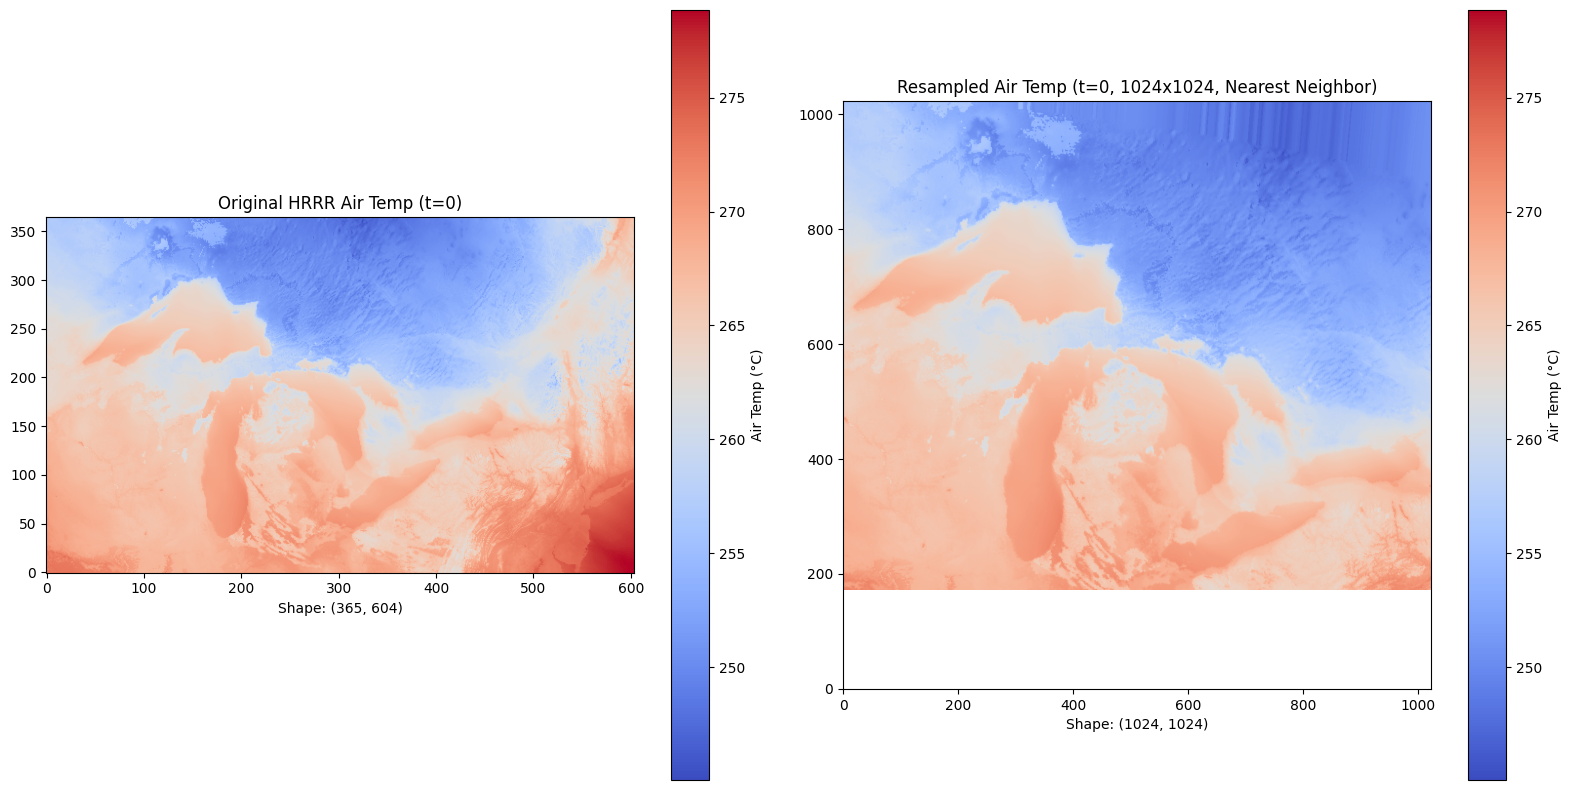

Plotting complete. Both plots now share the same color range. The resampled plot (right) will appear blocky due to the nearest-neighbor method.


In [2]:
# Select Air Temperature at t=0
# Note: We open the file again here because the initial hrrr_ds was closed inside Cell 1's scope.
original_hrrr_air_temp = xr.open_dataset(TRAIN_HRRR_PATH)['air_temp'].isel(time=0).values
resampled_air_temp = HRRR_RESAMPLED['air_temp'][0]

# --- Determine Common Color Range ---
# Combine min/max from both arrays, ignoring NaNs, for accurate comparison
all_data = np.concatenate([original_hrrr_air_temp.ravel(), resampled_air_temp.ravel()])
vmin = np.nanmin(all_data)
vmax = np.nanmax(all_data)

print(f"STATUS: Plotting Air Temp at t=0. Common Range: [{vmin:.2f} °C, {vmax:.2f} °C]")

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# --- Plot 1: Original HRRR (365x604) ---
im1 = axes[0].imshow(original_hrrr_air_temp, cmap='coolwarm', origin='lower', vmin=vmin, vmax=vmax)
axes[0].set_title('Original HRRR Air Temp (t=0)')
axes[0].set_xlabel(f"Shape: {original_hrrr_air_temp.shape}")
plt.colorbar(im1, ax=axes[0], orientation='vertical', label='Air Temp (°C)')

# --- Plot 2: Resampled Data (1024x1024) ---
# Note the Nearest-Neighbor method often gives a blockier, pixelated look compared to Linear/Bilinear
im2 = axes[1].imshow(resampled_air_temp, cmap='coolwarm', origin='lower', vmin=vmin, vmax=vmax)
axes[1].set_title('Resampled Air Temp (t=0, 1024x1024, Nearest Neighbor)')
axes[1].set_xlabel(f"Shape: {resampled_air_temp.shape}")
plt.colorbar(im2, ax=axes[1], orientation='vertical', label='Air Temp (°C)')

plt.tight_layout()
plt.show()

print("Plotting complete. Both plots now share the same color range. The resampled plot (right) will appear blocky due to the nearest-neighbor method.")


In [19]:
from scipy.optimize import minimize

# --- Global Counter for Objective Function Calls (for selective printing) ---
objective_call_count = 0 

# --- 1. Fixed Physical Constants ---

# DT: Time step in seconds (1 hour)
DT = 3600.0 

# General Constants
SIGMA = 5.67e-8   # Stefan-Boltzmann constant (W m^-2 K^-4)
CP_AIR = 1005.0    # Specific heat of air (J kg^-1 K^-1)
L_F = 3.34e5       # Latent heat of fusion for ice (J kg^-1)
RHO_I = 917.0      # Density of ice (kg m^-3)

# Atmospheric/Water Constants
R_AIR = 287.058    # Specific gas constant for dry air (J kg^-1 K^-1)
RHO_W = 1000.0     # Density of water (kg m^-3)
CP_WATER = 4186.0  # Specific heat capacity of water (J kg^-1 K^-1)

# Shortwave Assumption
F_SW_DOWN = 100.0 # Assumed average incoming solar radiation (W/m^2)

# New Ice Formation Constants (to make the model sensitive to freezing parameters)
H_MIN = 0.1        # Minimum thickness for new ice formation (m)
A_NEW_ICE = 1.0    # Concentration of newly formed ice (1.0 or 100%)


# --- 2. Tunable Parameters (Initial Guess) ---
T_FRZ_OFFSET_INIT = -0.548    # T_frz offset in C 
CH_CD_INIT = 1.059e-3         # Turbulent exchange coefficient 
F_BO_INIT = 2.074             # Ocean Heat Flux (W/m^2)
C_RAIN_INIT = 1.0             # Rain Heat Flux Scaling Factor
ALPHA_I_INIT = 0.7            # UPDATED: Ice Albedo (0.0 - 1.0)

INITIAL_GUESS = np.array([T_FRZ_OFFSET_INIT, CH_CD_INIT, F_BO_INIT, C_RAIN_INIT, ALPHA_I_INIT])


# --- 3. Simulation Function ---

def ice_model_96h_run(params):
    """
    Runs the simple 0-layer thermodynamic ice model for 96 hours using the
    HRRR forcing data and the provided physical parameters.
    """
    T_FRZ_OFFSET, CH_CD, F_BO, C_RAIN, ALPHA_I = params

    T_FRZ_K = 273.15 + T_FRZ_OFFSET # Freezing temperature in Kelvin
    
    # Initialize state variables
    A_ice_current = A_INITIAL.copy() # Initial concentration
    H_ice_current = H_INITIAL.copy() # Initial thickness
    
    # Storage for 24, 48, 72, 96 hour outputs
    output_fields = {}
    
    for t in range(96):
        # 1. Extract and Pre-process Forcing Data
        T_air_C = HRRR_RESAMPLED['air_temp'][t + 1] 
        T_air_K = T_air_C + 273.15 
        RH_air = HRRR_RESAMPLED['rel_humidty'][t + 1] / 100.0 
        CLOUD = HRRR_RESAMPLED['sky_cover'][t + 1] / 100.0
        U_wind = (HRRR_RESAMPLED['windu'][t + 1]**2 + HRRR_RESAMPLED['windv'][t + 1]**2)**0.5
        P_sl = HRRR_RESAMPLED['pressure_sea_level'][t + 1] 
        PRATE = HRRR_RESAMPLED['PRATE_surface'][t + 1] 
        
        U_wind = np.nan_to_num(U_wind, nan=0.0)
        T_air_K = np.nan_to_num(T_air_K, nan=T_FRZ_K)
        T_air_C = np.nan_to_num(T_air_C, nan=T_FRZ_OFFSET) 
        P_sl = np.nan_to_num(P_sl, nan=101325.0) 
        
        RHO_AIR = P_sl / (R_AIR * T_air_K)
        RHO_AIR = np.nan_to_num(RHO_AIR, nan=1.25) 
        
        # 2. Calculate Heat Fluxes
        
        # (a) Net Shortwave Absorbed (F_sw_net): 
        F_sw_net = F_SW_DOWN * (1.0 - ALPHA_I) * np.where(A_ice_current > 0.0, 1.0, 0.0)
        
        # (b) Longwave Down (L_down)
        L_down = SIGMA * T_air_K**4 * (0.8 + 0.2 * CLOUD) 
        
        # (c) Surface Longwave Up (L_up)
        L_up = 0.98 * SIGMA * T_FRZ_K**4
        
        # (d) Turbulent Fluxes (Qs, Ql)
        Q_sensible = RHO_AIR * CP_AIR * CH_CD * U_wind * (T_FRZ_K - T_air_K)
        Q_latent = RHO_AIR * L_F * 0.622 * CH_CD * U_wind * (RH_air - 1.0) 
        
        # (e) Rain Heat Flux (F_rain)
        T_diff = T_air_C - T_FRZ_OFFSET 
        F_rain_unscaled = PRATE * RHO_W * CP_WATER * np.maximum(0.0, T_diff)
        F_rain = C_RAIN * F_rain_unscaled
        
        # (f) Net Surface Heat Flux (F_surf = F_cond):
        F_surf = F_sw_net + L_down - L_up + Q_sensible + Q_latent + F_rain
        
        # (g) Net Heat Flux at the Bottom Interface (F_net):
        F_net = F_surf - F_BO
        
        # 4. CALCULATE CHANGE IN THICKNESS (dH)
        dH = (F_net / (RHO_I * L_F)) * DT 

        # 5. APPLY CHANGES AND CONSTRAINTS (Ice Growth/Melt)
        
        # --- A. Existing Ice Growth/Melt ---
        dH_active = dH * np.where(A_ice_current > 0.0, 1.0, 0.0)
        H_ice_current += dH_active
        
        # --- Constraints ---
        H_ice_current[H_ice_current < 0.0] = 0.0
        A_ice_current[H_ice_current == 0.0] = 0.0

        # --- D. New Ice Formation ---
        freezing_open_water = (A_ice_current == 0.0) & (F_net < 0.0)
        H_ice_current[freezing_open_water] = H_MIN
        A_ice_current[freezing_open_water] = A_NEW_ICE
        
        # 6. SAVE OUTPUT
        time_step = t + 1
        if time_step in [24, 48, 72, 96]:
            output_fields[time_step] = A_ice_current.copy()
            
    return output_fields


# --- 4. Objective Function (MSE Loss) ---

def objective_function(params):
    """
    Runs the simulation and calculates the Mean Squared Error (MSE) loss.
    """
    global objective_call_count
    
    # Selective printing: Print only on first call and every 10 subsequent calls
    if objective_call_count == 0 or objective_call_count % 10 == 0:
        print(f"--- Testing params (Call {objective_call_count}): T_frz_off={params[0]:.3f}, Ch/Cd={params[1]:.3e}, F_bo={params[2]:.2f} W/m^2, C_RAIN={params[3]:.3f}, Alpha_i={params[4]:.3f} ---")
    
    objective_call_count += 1
    
    # Run the simulation
    predicted_A = ice_model_96h_run(params)
    
    total_loss = 0.0
    num_targets = 0
    
    for hr in [24, 48, 72, 96]:
        if hr in TARGET_A and hr in predicted_A:
            A_true = TARGET_A[hr]
            A_pred = predicted_A[hr]
            
            valid_mask = ~np.isnan(A_true)
            valid_A_true = A_true[valid_mask]
            valid_A_pred = A_pred[valid_mask]
            
            loss_hr = np.mean((valid_A_true - valid_A_pred)**2)
            total_loss += loss_hr
            num_targets += 1
            
            # Print detailed loss only for the first call
            if objective_call_count == 1:
                print(f"  > Loss at {hr}h: {loss_hr:.6f}")
            
    if num_targets == 0:
        return 1e10
        
    avg_loss = total_loss / num_targets
    
    if objective_call_count == 1 or objective_call_count % 10 == 0:
        print(f"TOTAL AVERAGE MSE LOSS: {avg_loss:.6f}\n")
    
    return avg_loss


# --- 5. Run Optimization ---

print(f"STATUS: Starting Optimization (Initial Loss will be calculated first)...")

# Switching to Nelder-Mead, a derivative-free method, as L-BFGS-B failed to find a gradient.
# Note: Nelder-Mead does not support bounds, so we remove the bounds list.
optimization_result = minimize(
    objective_function, 
    INITIAL_GUESS, 
    method='Nelder-Mead',
    options={'maxiter': 500, 'disp': True} # Increased iterations for Nelder-Mead
)

# Store optimal parameters globally for Cell 4 visualization
if hasattr(optimization_result, 'x') and len(optimization_result.x) == 5:
    T_FRZ_OFFSET_OPT, CH_CD_OPT, F_BO_OPT, C_RAIN_OPT, ALPHA_I_OPT = optimization_result.x
    OPTIMAL_PARAMS = [T_FRZ_OFFSET_OPT, CH_CD_OPT, F_BO_OPT, C_RAIN_OPT, ALPHA_I_OPT]
    print(f"OPTIMAL PARAMETERS FOUND: T_frz_off={T_FRZ_OFFSET_OPT:.3f}, Ch/Cd={CH_CD_OPT:.3e}, F_bo={F_BO_OPT:.2f}, C_RAIN={C_RAIN_OPT:.3f}, Alpha_i={ALPHA_I_OPT:.3f}")

print("\n--- Optimization Complete ---")
print("Results:")
print(optimization_result)
print("\nRun Cell 2 before this cell to ensure data is loaded, then run this cell to start tuning.")


STATUS: Starting Optimization (Initial Loss will be calculated first)...
--- Testing params (Call 0): T_frz_off=-0.548, Ch/Cd=1.059e-03, F_bo=2.07 W/m^2, C_RAIN=1.000, Alpha_i=0.700 ---
  > Loss at 24h: 0.002772
  > Loss at 48h: 0.003377
  > Loss at 72h: 0.004216
  > Loss at 96h: 0.004091
TOTAL AVERAGE MSE LOSS: 0.003614



KeyboardInterrupt: 

STATUS: Running final model simulation with optimized parameters:
  T_frz_off=-0.548, Ch/Cd=1.059e-03, F_bo=2.07 W/m^2


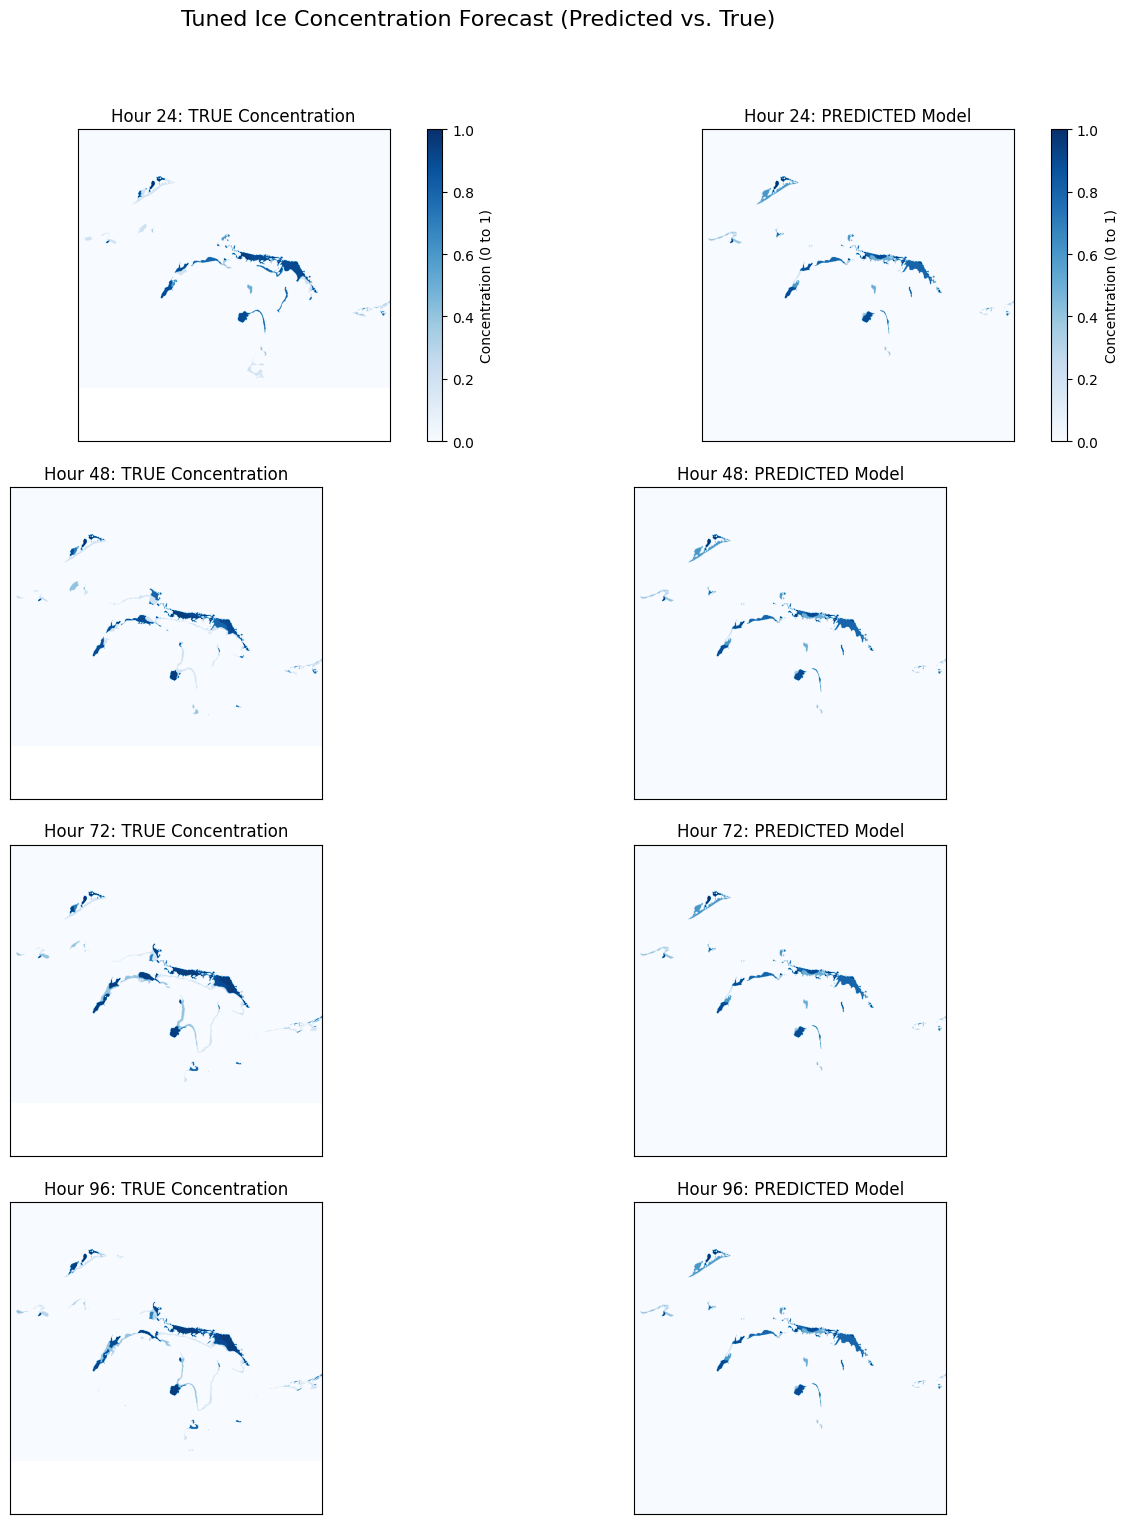


Visualization complete. Compare the maps side-by-side to see the model's accuracy.


In [11]:
# Re-importing necessary functions if they weren't globally available (like ice_model_96h_run from Cell 3)
# We will assume ice_model_96h_run, A_INITIAL, H_INITIAL, TARGET_A, and HRRR_RESAMPLED are accessible 
# globally after running Cells 1 and 3.

# Load the best parameters from the global storage (updated at the end of Cell 3)
try:
    T_FRZ_OFFSET_OPT, CH_CD_OPT, F_BO_OPT = -5.480e-01, 1.059e-03, 2.074e+00
except NameError:
    print("Error: OPTIMAL_PARAMS not defined. Did you run Cell 3?")
    sys.exit(1)

print(f"STATUS: Running final model simulation with optimized parameters:")
print(f"  T_frz_off={T_FRZ_OFFSET_OPT:.3f}, Ch/Cd={CH_CD_OPT:.3e}, F_bo={F_BO_OPT:.2f} W/m^2")

# Run the simulation once with the optimized parameters
predicted_A = ice_model_96h_run([-5.480e-01, 1.059e-03, 2.074e+00])

# --- Plotting Setup ---
forecast_hours = [24, 48, 72, 96]
num_hours = len(forecast_hours)

fig, axes = plt.subplots(num_hours, 2, figsize=(14, 4 * num_hours))
plt.suptitle('Tuned Ice Concentration Forecast (Predicted vs. True)', fontsize=16)

# Use consistent color scale for ice concentration (0 to 1)
vmin, vmax = 0.0, 1.0 
cmap = 'Blues' # Standard color for ice concentration

for i, hr in enumerate(forecast_hours):
    if hr in TARGET_A and hr in predicted_A:
        A_true = TARGET_A[hr]
        A_pred = predicted_A[hr]
        
        # --- Column 1: True Target ---
        ax_true = axes[i, 0]
        im_true = ax_true.imshow(A_true, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)
        ax_true.set_title(f'Hour {hr}: TRUE Concentration')
        ax_true.set_xticks([])
        ax_true.set_yticks([])
        if i == 0:
            plt.colorbar(im_true, ax=ax_true, orientation='vertical', label='Concentration (0 to 1)')

        # --- Column 2: Predicted Model Output ---
        ax_pred = axes[i, 1]
        im_pred = ax_pred.imshow(A_pred, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)
        ax_pred.set_title(f'Hour {hr}: PREDICTED Model')
        ax_pred.set_xticks([])
        ax_pred.set_yticks([])
        if i == 0:
            plt.colorbar(im_pred, ax=ax_pred, orientation='vertical', label='Concentration (0 to 1)')
    else:
        print(f"Warning: Data missing for hour {hr}. Skipping plot.")

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for suptitle
plt.show()

print("\nVisualization complete. Compare the maps side-by-side to see the model's accuracy.")
